(ctrexamples)=
## Uncertainty of unique clicks rate in searches:

We are going to compute the CTR (ratio betwen daily searchers with at least one click over total daily searches) in one marketplace and we are ging to see the uncertainty of the value every day.

One possible applications of this is measure  feature flag effecct for example or quantify the variability that pur simple statistics have.

[Here](https://towardsdatascience.com/bayesian-inference-intuition-and-example-148fd8fb95d6) an article of reference.



In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from operator import itemgetter
%matplotlib inline

### Preparing teh dataset

We are going to use the following dataset (LINK)



In [2]:
searches = pd.read_csv("../../../bayesian-course/datasets-toys/datasets/searches_with_clicks.csv")
searches['click_bool'] = (searches['nof_clicks']>0).astype(int)
searches.head()

,date,nof_clicks,nof_listing_pages_in_the_search,click_bool
0,2021-03-05,4,7,1
1,2021-03-04,3,1,1
2,2021-03-05,6,3,1
3,2021-03-06,48,59,1
4,2021-03-06,4,1,1


We have about 1.08M searches with the total number of clicks and the number of pages done in the search.

In [13]:
data = searches.groupby("date").agg({'click_bool':'sum','nof_listing_pages_in_the_search':'count'})
data['ctr'] =  data['click_bool']/data['nof_listing_pages_in_the_search']
data.columns = ['nof_searches_with_clicks', 'nof_searches', 'uctr']
data

,nof_searches_with_clicks,nof_searches,uctr
date,,,
2021-03-01,35610,65769,0.541440
2021-03-02,60866,110757,0.549545
2021-03-03,60883,110467,0.551142
2021-03-04,59959,109040,0.549881
2021-03-05,57267,105247,0.544120
2021-03-06,54891,100493,0.546217
2021-03-07,59305,108108,0.548572
2021-03-08,59653,108763,0.548468
2021-03-09,59679,108558,0.549743


In [18]:
data_dt = data[data.index=='2021-03-01'].copy()
data_dt

,nof_searches_with_clicks,nof_searches,uctr
date,,,
2021-03-01,35610,65769,0.54144


For every day we know:

- $\theta$ is the probability that one search has one click (this is following a Benoulli($\theta$)
- Random variable $X$ which represnets number of searches with clicks during a day follows a binomial distributions $B(n,\theta)$ where $n$ is the number of total daily searches and $\theta$ is the probability that one search has one click . Then, the unique CTR (uctr) is the expected value of this distribution:

$$
E(X) = \theta = uctr
$$

We want to create a model for the daily unique click rate (uctr) using bayesian statistics.

Bayesian Inference has three steps.

Step 1. [Prior] Choose a PDF to model your parameter $\theta$, aka the prior distribution P($\theta$). This is your best guess about parameters before seeing the data X.

Step 2. [Likelihood] Choose a PDF for P(X|$\theta$). Basically you are modeling how the data X will look like given the parameter $\theta$.

Step 3. [Posterior] Calculate the posterior distribution P($\theta$|X) and pick the $\theta$ that has the highest P($\theta$|X).
And the posterior becomes the new prior. Repeat step 3 as you get more data.


#### STEP 1: Prior P($\theta$)

We can start with a weak prior, for example:
$$
P(\theta) = \beta(1,1)
$$

In [159]:
import scipy.stats as stats
import matplotlib.pyplot as plt
a = 1
b = 1
# domain θ
theta_range = np.linspace(0, 1, 1000)
# prior distribution P(θ)
prior = stats.beta.pdf(x = theta_range, a=a, b=b)

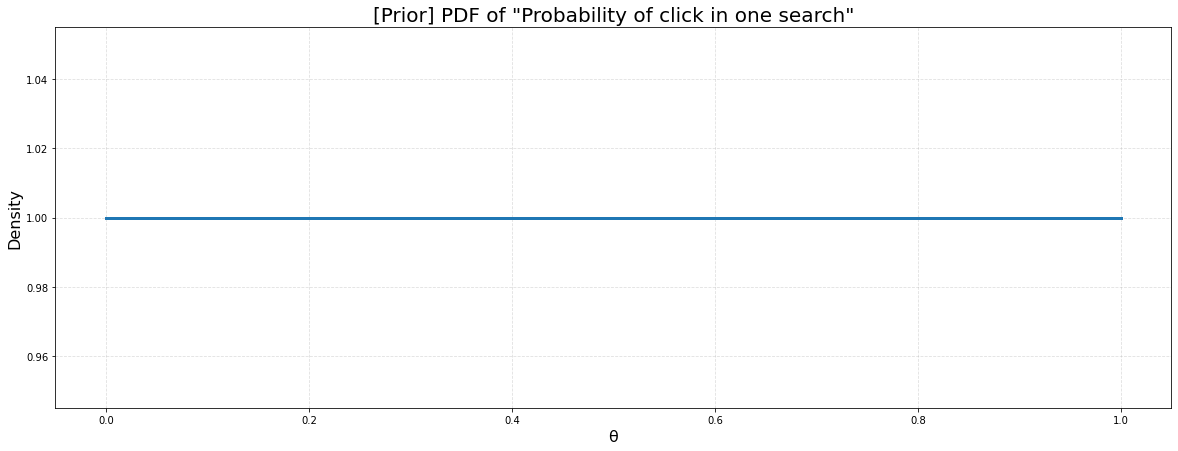

In [160]:
# Plotting the prior distribution 
plt.rcParams['figure.figsize'] = [20, 7]
fig, ax = plt.subplots()
plt.plot(theta_range, prior, linewidth=3)
# Add a title
plt.title('[Prior] PDF of "Probability of click in one search"', fontsize=20)
# Add X and y Label
plt.xlabel('θ', fontsize=16)
plt.ylabel('Density', fontsize=16)
# Add a grid
plt.grid(alpha=.4, linestyle='--')
# Show the plot
plt.show()

#### STEP 2: Likelihood P($X|\theta$)

X is a binary distribution, and we have the total number of searches and we want the probability oto do a clcik in one search $\theta$.
The if we want to compute P($X|\theta$), basically this is a binomial with parameters n=size and p = $\theta$

In [55]:
# The sampling dist P(X|θ) with a prior θ
likelihood = stats.binom.pmf(k = np.sum(data_dt['nof_searches_with_clicks']), \
                             n = data_dt['nof_searches'], \
                             p = a/(a+b))
likelihood

array([1.89708153e-101])

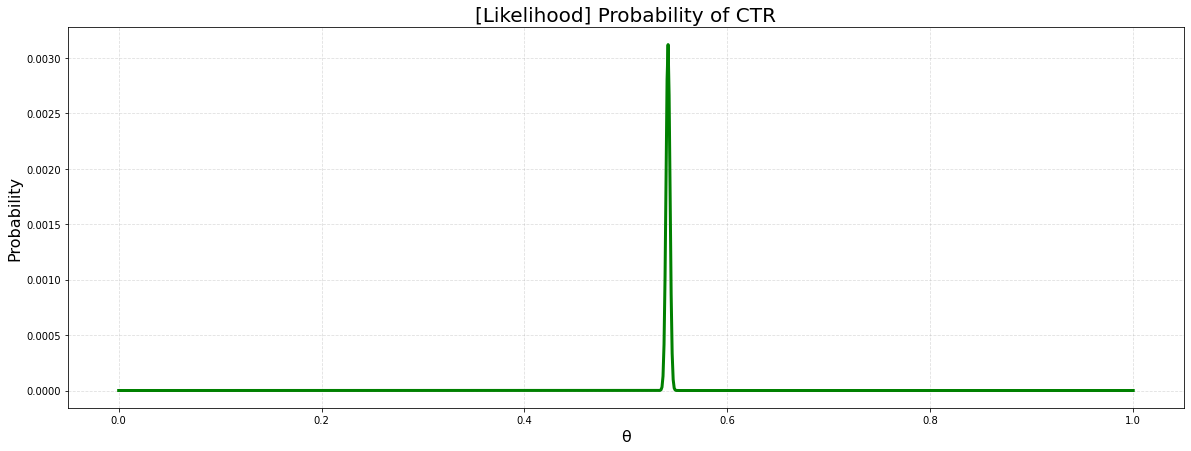

In [57]:
# Likelihood P(X|θ) for all θ's
likelihood = stats.binom.pmf(k = np.sum(data_dt['nof_searches_with_clicks']),n = data_dt['nof_searches'],\
                             p = theta_range)
# Create the plot
fig, ax = plt.subplots()
plt.plot(theta_range, likelihood, linewidth=3, color='green')
# Add a title
plt.title('[Likelihood] Probability of CTR' , fontsize=20)
# Add X and y Label
plt.xlabel("θ", fontsize=16)
plt.ylabel("Probability", fontsize=16)
# Add a grid
plt.grid(alpha=.4, linestyle='--')
# Show the plot
plt.show()

#### STEP 3: Posteriori P($\theta|X$)

If your prior is a distribution $\beta(a,b)$, the posteriori distribution is $\beta(a+k,b+n-k)$ where
$k$ is the number of searches with clicks and $n$ total number of searches.

In [161]:
a = 1
b = 1
k = data_dt['nof_searches_with_clicks']
n = data_dt['nof_searches']
# domain θ
theta_range = np.linspace(0, 1, 1000)
# posterior distribution P(θ|X)
posterior = stats.beta.pdf(x = theta_range, a=a+k, b=b+n-k)

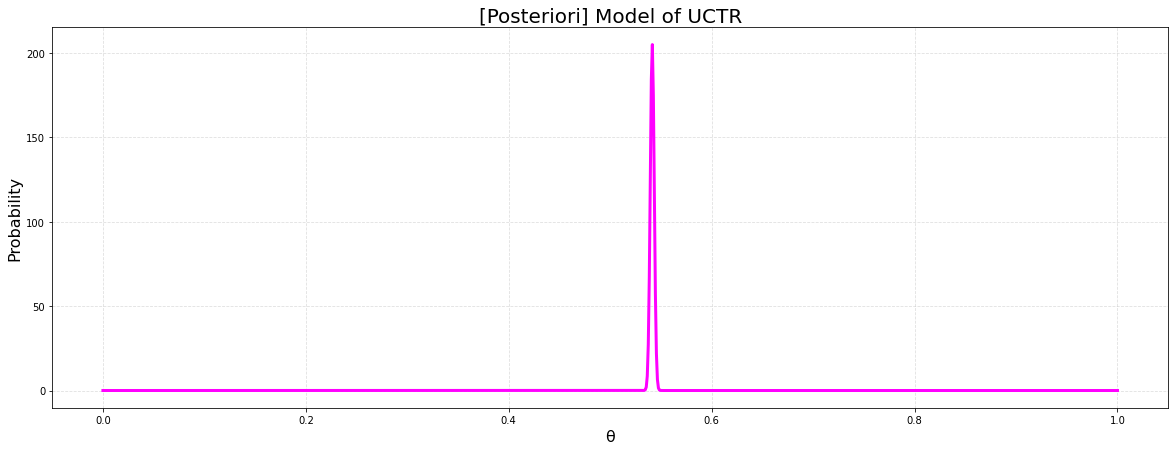

In [75]:
# Create the plot
fig, ax = plt.subplots()
plt.plot(theta_range, posterior, linewidth=3, color='magenta')
# Add a title
plt.title('[Posteriori] Model of UCTR' , fontsize=20)
# Add X and y Label
plt.xlabel("θ", fontsize=16)
plt.ylabel("Probability", fontsize=16)
# Add a grid
plt.grid(alpha=.4, linestyle='--')
# Show the plot
plt.show()

### Computations of the Credible intervals with this posteriori 

In [167]:
cl,cu = stats.beta.ppf(0.025,a+k,b+n-k)[0],stats.beta.ppf(0.975,a+k,b+n-k)[0]
cl,cu

(0.5376300204361092, 0.5452460648094737)

(0.5176300204361092, 0.5652460648094737)

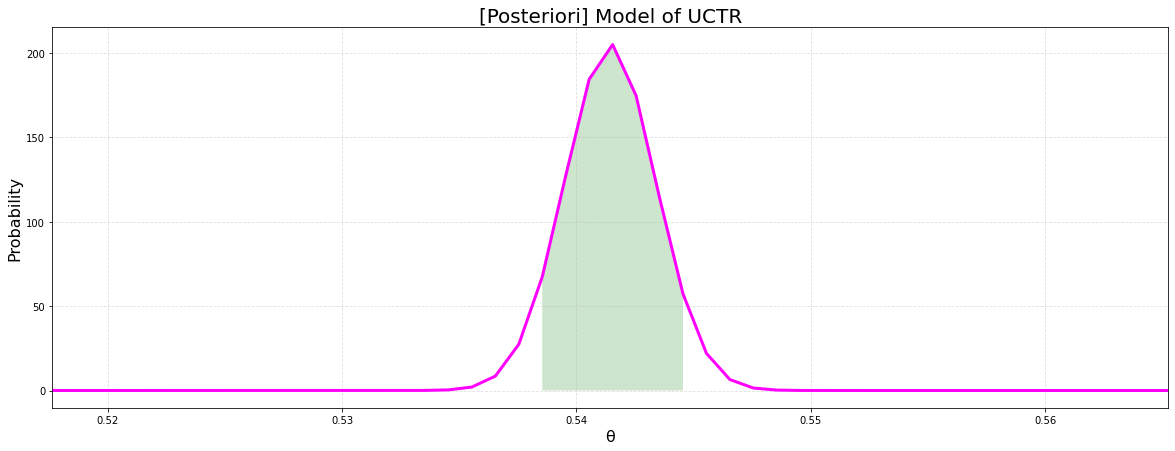

In [174]:
# Create the plot
fig, ax = plt.subplots()
plt.plot(theta_range, posterior, linewidth=3, color='magenta')
# Add a title
plt.title('[Posteriori] Model of UCTR' , fontsize=20)
# Add X and y Label
plt.xlabel("θ", fontsize=16)
plt.ylabel("Probability", fontsize=16)
# Add a grid
plt.grid(alpha=.4, linestyle='--')
xs = theta_range[(cl < theta_range) & (cu >theta_range)]
ps = posterior[(cl < theta_range) & (cu >theta_range)]
plt.fill_between(xs,posterior.min(), ps,facecolor='green', interpolate=True, alpha=0.2)
plt.xlim([cl-0.02,cu+0.02])

### We are going to ompute the credible interval for every day and plot

In [122]:
def credible_intervale(dt,df,a,b):
    data_dt = df[df.index==dt].copy()
    k = data_dt['nof_searches_with_clicks']
    n = data_dt['nof_searches']
    cl,cu = stats.beta.ppf(0.025,a+k,b+n-k)[0],stats.beta.ppf(0.975,a+k,b+n-k)[0]
    return cl,cu,data_dt['uctr'][0]

In [120]:
credible_intervale('2021-03-01',data,a=1,b=1)

(0.5376300204361092, 0.5452460648094737, 0.5414404962824431)

In [155]:
dic = {}
for dt in data.index:
    cl,cu,uctr = credible_intervale(dt,data,a,b)
    dic[dt] = cl,cu,uctr

In [134]:
result = pd.DataFrame.from_dict(dic).transpose()
result.columns = ["lower",'upper','uctr']
result

,lower,upper,uctr
2021-03-01,0.537630,0.545246,0.541440
2021-03-02,0.546614,0.552474,0.549545
2021-03-03,0.548207,0.554073,0.551142
2021-03-04,0.546926,0.552832,0.549881
2021-03-05,0.541109,0.547127,0.544120
2021-03-06,0.543137,0.549293,0.546217
2021-03-07,0.545604,0.551536,0.548572
2021-03-08,0.545509,0.551424,0.548468
2021-03-09,0.546782,0.552701,0.549743
2021-03-10,0.546524,0.552432,0.549480


<ipython-input-158-328ba4725e29>:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r_-" (-> color='r'). The keyword argument will take precedence.
  plt.plot((y,y),(lower,upper),'r_-',color='red')


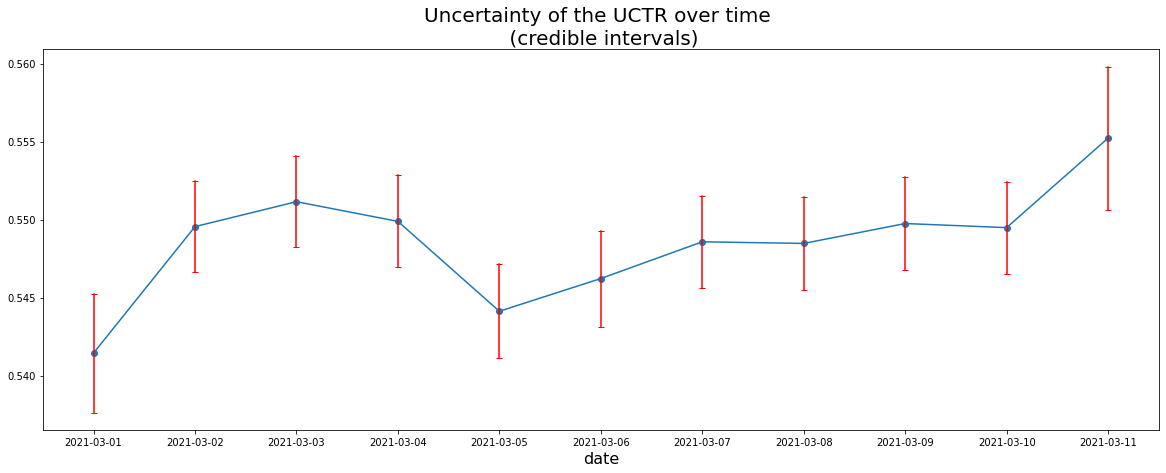

In [158]:
fig, ax = plt.subplots()
plt.plot(result.index, result['uctr'],marker='o')
for lower,upper,y in zip(result['lower'],result['upper'],range(result.shape[0])):
    plt.plot((y,y),(lower,upper),'r_-',color='red')
plt.xticks(range(result.shape[0]),list(result.index))
plt.title('Uncertainty of the UCTR over time \n (credible intervals)' , fontsize=20)
# Add X and y Label
_ = plt.xlabel("date", fontsize=16)

### Appendix

In [151]:
theta_range_e = theta_range + 0.001 
#prior = stats.beta.cdf(x = theta_range_e, a=a, b=b) - stats.beta.cdf(x = theta_range, a=a, b=b)  
prior = stats.beta.pdf(x = theta_range, a=a, b=b)
likelihood = stats.binom.pmf(k = np.sum(data_dt['nof_searches_with_clicks']),n = data_dt['nof_searches'],p = theta_range) 
posterior = likelihood * prior # element-wise multiplication
normalized_posterior = posterior / np.sum(posterior)


In [66]:
np.argmax(prior)

8

In [67]:
np.argmax(likelihood)

541

In [68]:
np.argmax(posterior)

541

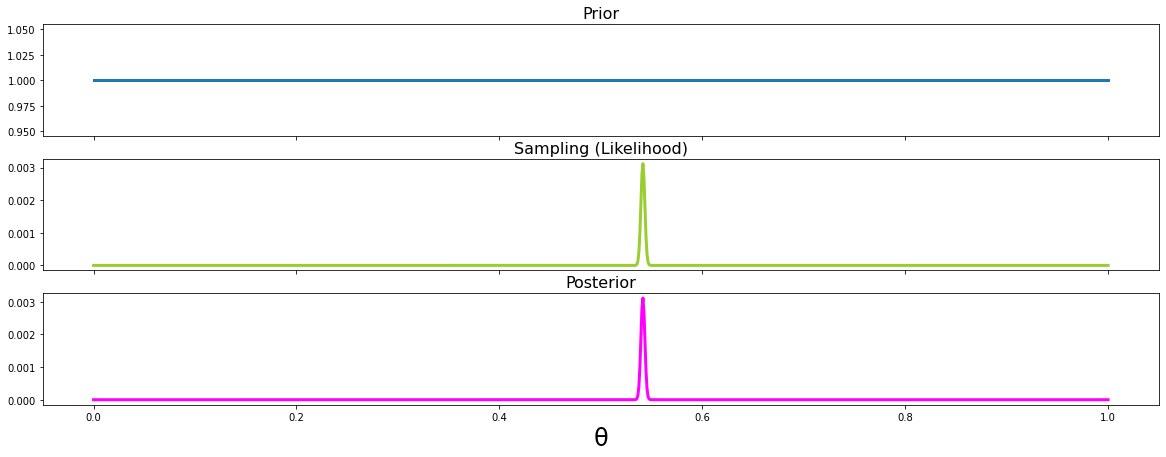

In [153]:
# Plotting all three together
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(20,7))
plt.xlabel('θ', fontsize=24)
axes[0].plot(theta_range, prior, label="Prior", linewidth=3)
axes[0].set_title("Prior", fontsize=16)
axes[1].plot(theta_range, likelihood, label="Likelihood", linewidth=3, color='yellowgreen')
axes[1].set_title("Sampling (Likelihood)", fontsize=16)
axes[2].plot(theta_range, posterior, label='Posterior', linewidth=3, color='magenta')
axes[2].set_title("Posterior", fontsize=16)
plt.show()
